in order to run deep learning experiments on GPU, you will have to change the runtime to GPU this way:

top menu: Runtime / Change runtime type / Hardware accelerator: GPU



In [0]:
# install requirements:
#  SPTK for speech synthesis,
#  SoX for sound conversion,
#  PySPTK for spectrogram
!apt install sptk
!apt install sox
!pip3 install pysptk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tcsh
The following NEW packages will be installed:
  sptk tcsh
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 798 kB of archives.
After this operation, 3,754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 sptk amd64 3.9-1 [369 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tcsh amd64 6.20.00-7 [428 kB]
Fetched 798 kB in 3s (309 kB/s)
Selecting previously unselected package sptk.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../archives/sptk_3.9-1_amd64.deb ...
Unpacking sptk (3.9-1) ...
Selecting previously unselected package tcsh.
Preparing to unpack .../t

In [0]:
# mount my own google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# check contents of my google drive
import os
os.chdir("/content/gdrive/My Drive/")
!ls -al

total 396604
-rw------- 1 root root   1366740 Jul 13  2015 '2008.12.21 letöltés 001.jpg'
drwx------ 3 root root      4096 Dec  1 19:30  2017-2018-2019
-rw------- 1 root root  41419490 Sep  9  2018  358986411-keynote-upper-intermediate-student-s-book-pdf.pdf
drwx------ 3 root root      4096 Feb  6  2018  4.félév
-rw------- 1 root root         1 Jan 25 15:40 '6. félév órarend.gsheet'
drwx------ 2 root root      4096 Dec 14  2017 'Ádám meglepi'
drwx------ 2 root root      4096 Mar  3 10:50  BEST
drwx------ 2 root root      4096 May  2  2018 'Bogi '
drwx------ 2 root root      4096 Feb 23  2018  boldi_angyalai
-rw------- 1 root root         1 Dec  7 16:09 'BSc szakmai gyakorlat 2018 @ Morgan Stanley.gsheet'
drwx------ 2 root root      4096 Sep 13 14:08  Classroom
drwx------ 2 root root      4096 Nov 23 12:29 'Colab Notebooks'
drwx------ 2 root root      4096 Jul 13  2015 'Családi képek'
drwx------ 2 root root      4096 Mar  1 17:14 'Dani felvételi'
drwx------ 2 root root      4

In [0]:
# create new folder for output
dir_output = "/content/gdrive/My Drive/deep_learning_VID2SPEECH/"
if not os.path.exists(dir_output):
  os.mkdir(dir_output)
os.chdir(dir_output)
!pwd

/content/gdrive/My Drive/deep_learning_VID2SPEECH


---

functions that will be used later


In [0]:
# vocoder for synthesis

# vocoder_SPTK.py

from subprocess import run
import numpy as np
import scipy.io.wavfile as io_wav


def encode(basefilename, Fs_new = 11050, frlen = 512, frshft = 200, order = 12, alpha = 0.42, stage = 3, minF0 = 50, maxF0 = 400):
    
    # from HTS Makefile
    # $(X2X) +sf $${raw} | $(PITCH) -H $(UPPERF0) -L $(LOWERF0) -p $(FRAMESHIFT) -s $${SAMPKHZ} -o 2 > lf0/$${base}.lf0
    #
    # $(X2X) +sf $${raw} | \
    # $(FRAME) -l $(FRAMELEN) -p $(FRAMESHIFT) | \
    # $(WINDOW) -l $(FRAMELEN) -L $(FFTLEN) -w $(WINDOWTYPE) -n $(NORMALIZE) | \
    # $(MGCEP) -a $(FREQWARP) -c $(GAMMA) -m $(MGCORDER) -l $(FFTLEN) -e 1.0E-08 -o 4 | \
    # $(LPC2LSP) -m $(MGCORDER) -s $${SAMPKHZ} $${GAINOPT} -n $(FFTLEN) -p 8 -d 1.0E-08 > mgc/$${base}.mgc; \
    
    # calculate MGC-LSP
    command = 'sox ' + basefilename + '.wav' + ' -t raw -r ' + str(Fs_new) + ' - ' + ' | x2x +sf | ' + \
              'frame -l ' + str(frlen) + ' -p ' + str(frshft) + ' | ' + \
              'window -l ' + str(frlen) + ' -L ' + str(frlen) + ' -w 0 -n 1 | ' + \
              'mgcep -a ' + str(alpha) + ' -c ' + str(stage) + ' -m ' + str(order) + ' -l ' + str(frlen) + ' -e 1.0E-08 -o 4 | ' + \
              'lpc2lsp -m ' + str(order) + ' -s ' + str(Fs_new / 1000) + ' -n ' + str(frlen) + ' -p 8 -d 1.0E-08 > ' + basefilename + '.mgclsp'
    # print(command)
    run(command, shell=True)
    
    # estimate pitch using SWIPE
    command = 'sox ' + basefilename + '.wav' + ' -t raw -r ' + str(Fs_new) + ' - ' + ' | x2x +sf | ' + \
              'pitch -a 1 -H ' + str(maxF0) + ' -L ' + str(minF0) + ' -p ' + str(frshft) + ' -s ' + str(Fs_new / 1000) + ' -o 2 > ' + basefilename + '.lf0'
    # print(command)
    run(command, shell=True)
    
    # read files for output
    mgc_lsp_coeff = np.fromfile(basefilename + '.mgclsp', dtype=np.float32).reshape(-1, order + 1)
    lf0 = np.fromfile(basefilename + '.lf0', dtype=np.float32)
    
    return (mgc_lsp_coeff, lf0)

def decode(mgc_lsp_coeff, lf0, basefilename_out, Fs = 11050, frlen = 512, frshft = 200, order = 12, alpha = 0.42, stage = 3):
    
    # from HTS Training.pl / gen_wave
    #
    # MGC-LSPs -> MGC coefficients
    # $line = "$LSPCHECK -m " . ( $ordr{'mgc'} - 1 ) . " -s " . ( $sr / 1000 ) . " $lgopt -c -r 0.1 -g -G 1.0E-10 $mgc | ";
    # $line .= "$LSP2LPC -m " . ( $ordr{'mgc'} - 1 ) . " -s " . ( $sr / 1000 ) . " $lgopt | ";
    # $line .= "$MGC2MGC -m " . ( $ordr{'mgc'} - 1 ) . " -a $fw -c $gm -n -u -M " . ( $ordr{'mgc'} - 1 ) . " -A $fw -C $gm " . " > $gendir/$base.c_mgc";
    # shell($line);
    #
    # $line = "$SOPR -magic -1.0E+10 -EXP -INV -m $sr -MAGIC 0.0 $lf0 > $gendir/${base}.pit";
    #
    # $line = "$EXCITE -n -p $fs $gendir/$base.pit | ";
    # $line .= "$DFS -b $lfil | $VOPR -a $gendir/$base.unv | ";
    # $line .= "$MGLSADF -P 5 -m " . ( $ordr{'mgc'} - 1 ) . " -p $fs -a $fw -c $gm $mgc | ";
    # $line .= "$X2X +fs -o > $gendir/$base.raw";
    # shell($line);
    
    # write files for SPTK
    mgc_lsp_coeff.astype('float32').tofile(basefilename_out + '.mgclsp')
    lf0.astype('float32').tofile(basefilename_out + '.lf0')
    
    # MGC-LSPs -> MGC coefficients
    command = 'sptk lspcheck -m ' + str(order) + ' -s ' + str(Fs / 1000) + ' -c -r 0.1 -g -G 1.0E-10 "' + basefilename_out + '.mgclsp"' + ' | ' + \
              'sptk lsp2lpc -m '  + str(order) + ' -s ' + str(Fs / 1000) + ' | ' + \
              'sptk mgc2mgc -m '  + str(order) + ' -a ' + str(alpha) + ' -c ' + str(stage) + ' -n -u ' + \
                      '-M '  + str(order) + ' -A ' + str(alpha) + ' -C ' + str(stage) + ' > "' + basefilename_out + '.mgc"'
    # print(command)
    run(command, shell=True)
    
    # MGLSADF synthesis based on pitch and MGC coefficients
    command = 'sptk sopr -magic -1.0E+10 -EXP -INV -m ' + str(Fs) + ' -MAGIC 0.0 "' + basefilename_out + '.lf0"' + ' | ' + \
              'sptk excite -n -p ' + str(frshft) + ' | ' + \
              'sptk mglsadf -P 5 -m ' + str(order) + ' -p ' + str(frshft) + ' -a ' + str(alpha) + ' -c ' + str(stage) + ' "' + basefilename_out + '.mgc"' + ' | ' + \
              'sptk x2x +fs -o | sox -c 1 -b 16 -e signed-integer -t raw -r ' + str(Fs) + ' - -t wav -r ' + str(Fs) + ' "' + basefilename_out + '.wav"'
    # print(command)
    run(command, shell=True)
    
    # read file for output
    (Fs_out, x_synthesized) = io_wav.read(basefilename_out + '.wav')
    
    return x_synthesized

In [0]:
# from LIP_SSI_DNN_GRID.py

# required modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as io_wav
import os
import os.path
import gc
import re
import csv
import datetime
import scipy
import pickle
import cv2

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, CSVLogger

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, IncrementalPCA

Using TensorFlow backend.


In [0]:
# from LipReading
################## VIDEO INPUT WITH DIFF ##################
def load_video_3D(path):
    
    cap = cv2.VideoCapture(path)
    frameCount = THRESH_FRAME_COUNT
    frameHeight=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT ))
    frameWidth=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH ))

    buf =np.empty((frameHeight, frameWidth, frameCount), np.dtype('float32'))
    fc = 0
    ret = True
    
    while (fc < frameCount  and ret):
        ret, frame = cap.read()
        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame=frame.astype('float32')
        #frame = frame-np.mean(frame)
        #frame = frame/np.std(frame)
        frame = frame-np.amin(frame)
        frame = frame/np.amax(frame)
        buf[:,:,fc]=frame
        fc += 1
    cap.release()

    return buf

In [0]:
def get_mgc_lsp_coeff(basefilename):
    if os.path.isfile(basefilename + '.mgclsp'):
        mgc_lsp_coeff = np.fromfile(basefilename + '.mgclsp', dtype=np.float32).reshape(-1, order + 1)
        lf0 = np.fromfile(basefilename + '.lf0', dtype=np.float32)
    else:
        ValueError('MGC not available for ' + basefilename)
    return (mgc_lsp_coeff, lf0)

In [0]:
# download data and extract
if not os.path.isfile('GRID_s3_cut.tar.gz'):
  !wget http://smartlab.tmit.bme.hu/csapo/GRID/GRID_s3_cut.tar.gz
  !tar -xzvf GRID_s3_cut.tar.gz
!ls -al GRID/

total 8
drwx------ 2 root root 4096 Feb 19 14:57 Audio
drwx------ 2 root root 4096 Feb 19 14:57 Video


In [0]:
# TODO: modify this according to your data path
speaker = 's3'
dir_video = dir_output + 'GRID/Video/' + speaker + '/face/'
dir_audio = dir_output + 'GRID/Audio/' + speaker + '/'


In [0]:
# Parameters of vocoder
samplingFrequency = 8000
frameLength = 1024 # 93 ms at 22050 Hz sampling
frameShift = 320 # 40 ms at 8000 Hz sampling, correspondong to 25 fps (lip video)
order = 12
alpha = 0.42
stage = 3
THRESH_FRAME_COUNT = 75

In [0]:
n_files = 900
n_file = 0
n_max_lip_frames = n_files * THRESH_FRAME_COUNT
n_lines = 128
n_pixels = 128
n_lines_reduced = 128
n_pixels_reduced = 128
n_mgc = order + 1
n_lip = n_lines_reduced * n_pixels_reduced
n_pca = 200
lip = np.empty((n_max_lip_frames, n_lip))
mgc = np.empty((n_max_lip_frames, n_mgc))
lip_size = 0
mgc_size = 0

In [0]:
if os.path.isdir(dir_video):
    for file in sorted(os.listdir(dir_video)):
        if ".avi" in file and n_file < n_files: # and "0088" in file:
            try:
                lip_data = load_video_3D(dir_video + file)
                (mgc_lsp_coeff, lf0) = get_mgc_lsp_coeff(dir_audio + file[:-4])
            except ValueError as e:
                print("wrong data, check manually!", e)
            
            else:
                n_file += 1
                
                mgc_lip_len = np.min((lip_data.shape[2], len(mgc_lsp_coeff)))
                
                lip_data = lip_data[:, :, 0:mgc_lip_len]
                mgc_lsp_coeff = mgc_lsp_coeff[0:mgc_lip_len]
                
                print(file[:-4], lip_data.shape, mgc_lsp_coeff.shape)
                
                # resize
                lip_len = lip_data.shape[2]
                if lip_size + lip_len > n_max_lip_frames:
                    raise
                for i in range(lip_len):
                    # lip[lip_size + i] = scipy.misc.imresize(lip_data[i], (n_lines_reduced, n_pixels_reduced), interp='bicubic') # 64x64
                    lip[lip_size + i] = lip_data[:, :, i].ravel() # original, 128x128
                    mgc[mgc_size + i] = mgc_lsp_coeff[i]

                lip_size += lip_len
                mgc_size += lip_len
                
                print('n_frames_all: ', lip_size, 'mgc_size: ', mgc_size)
                # calculate mgc features

lip = lip[0 : lip_size]
mgc = mgc[0 : mgc_size]

000001 (128, 128, 75) (75, 13)
n_frames_all:  75 mgc_size:  75
000002 (128, 128, 75) (75, 13)
n_frames_all:  150 mgc_size:  150
000003 (128, 128, 75) (75, 13)
n_frames_all:  225 mgc_size:  225
000004 (128, 128, 75) (75, 13)
n_frames_all:  300 mgc_size:  300
000005 (128, 128, 75) (75, 13)
n_frames_all:  375 mgc_size:  375
000006 (128, 128, 75) (75, 13)
n_frames_all:  450 mgc_size:  450
000007 (128, 128, 75) (75, 13)
n_frames_all:  525 mgc_size:  525
000008 (128, 128, 75) (75, 13)
n_frames_all:  600 mgc_size:  600
000009 (128, 128, 75) (75, 13)
n_frames_all:  675 mgc_size:  675
000010 (128, 128, 75) (75, 13)
n_frames_all:  750 mgc_size:  750
000011 (128, 128, 75) (75, 13)
n_frames_all:  825 mgc_size:  825
000012 (128, 128, 75) (75, 13)
n_frames_all:  900 mgc_size:  900
000013 (128, 128, 75) (75, 13)
n_frames_all:  975 mgc_size:  975
000014 (128, 128, 75) (75, 13)
n_frames_all:  1050 mgc_size:  1050
000015 (128, 128, 75) (75, 13)
n_frames_all:  1125 mgc_size:  1125
000016 (128, 128, 75) (

In [0]:
print(lip.shape, mgc.shape)

(67500, 16384) (67500, 13)


In [0]:
# use 90% of data for training, 10% for validation
lip_training = lip[0 : int(0.9*lip_size)]
lip_validation = lip[int(0.9*lip_size) : ]
mgc_training = mgc[0 : int(0.9*mgc_size)]
mgc_validation = mgc[int(0.9*mgc_size) : ]

In [0]:
# apply PCA to decrease input size
# use IncrementalPCA to fit into RAM
lip_pca = IncrementalPCA(n_components = n_pca, batch_size=100)
n = lip_training.shape[0] # how many rows we have in the dataset
chunk_size = 1000 # how many rows we feed to IPCA at a time, the divisor of n
for i in range(0, n//chunk_size):
    print('pca partial fit: ', i, '/', n//chunk_size)
    lip_pca.partial_fit(lip_training[i*chunk_size : (i+1)*chunk_size])

#lip_training_pca = lip_pca.transform(lip_training)
    
lip_training_pca = np.empty((n_max_lip_frames, n_pca))
for i in range(0, n//chunk_size):
    print('pca partial transform: ', i, '/', n//chunk_size)
    lip_training_pca[i*chunk_size : (i+1)*chunk_size] = lip_pca.transform(lip_training[i*chunk_size : (i+1)*chunk_size])


pca partial fit:  0 / 60
pca partial fit:  1 / 60
pca partial fit:  2 / 60
pca partial fit:  3 / 60
pca partial fit:  4 / 60
pca partial fit:  5 / 60
pca partial fit:  6 / 60
pca partial fit:  7 / 60
pca partial fit:  8 / 60
pca partial fit:  9 / 60
pca partial fit:  10 / 60
pca partial fit:  11 / 60
pca partial fit:  12 / 60
pca partial fit:  13 / 60
pca partial fit:  14 / 60
pca partial fit:  15 / 60
pca partial fit:  16 / 60
pca partial fit:  17 / 60
pca partial fit:  18 / 60
pca partial fit:  19 / 60
pca partial fit:  20 / 60
pca partial fit:  21 / 60
pca partial fit:  22 / 60
pca partial fit:  23 / 60
pca partial fit:  24 / 60
pca partial fit:  25 / 60
pca partial fit:  26 / 60
pca partial fit:  27 / 60
pca partial fit:  28 / 60
pca partial fit:  29 / 60
pca partial fit:  30 / 60
pca partial fit:  31 / 60
pca partial fit:  32 / 60
pca partial fit:  33 / 60
pca partial fit:  34 / 60
pca partial fit:  35 / 60
pca partial fit:  36 / 60
pca partial fit:  37 / 60
pca partial fit:  38 /

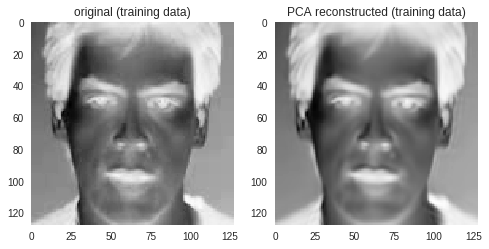

In [0]:
# show sample images
plt.subplot(121)
plt.imshow(lip_training[1000].reshape(n_lines, n_pixels))
plt.title('original (training data)')
plt.grid(False)
plt.subplot(122)
plt.imshow(lip_pca.inverse_transform(lip_training_pca[1000]).reshape(n_lines, n_pixels))
plt.title('PCA reconstructed (training data)')
plt.grid(False)

In [0]:
# correct mgc length
lip_training_pca = lip_training_pca[0:i*chunk_size]
mgc_training = mgc_training[0:i*chunk_size]

In [0]:
# scale input to [0-1] range
lip_scaler = MinMaxScaler(feature_range=(0, 1))
lip_training_scaled = lip_scaler.fit_transform(lip_training_pca)


In [0]:
# apply the same scaling on the validation data
lip_validation = lip_scaler.transform(lip_pca.transform(lip_validation))

In [0]:
# remove old variable to free memory
del lip

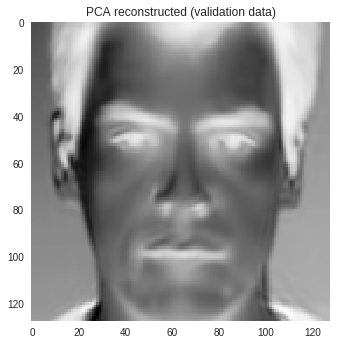

In [0]:
plt.imshow(lip_pca.inverse_transform(lip_scaler.inverse_transform(lip_validation[0].reshape(1, -1))).reshape(n_lines, n_pixels))
plt.title('PCA reconstructed (validation data)')
plt.grid(False)

In [0]:
# target: normalization to zero mean, unit variance
# feature by feature

mgc_scalers = []
for i in range(n_mgc):
    mgc_scaler = StandardScaler(with_mean=True, with_std=True)
    mgc_scalers.append(mgc_scaler)
    mgc_training[:, i] = mgc_scalers[i].fit_transform(mgc_training[:, i].reshape(-1, 1)).ravel()
    mgc_validation[:, i] = mgc_scalers[i].transform(mgc_validation[:, i].reshape(-1, 1)).ravel()


In [0]:
print(lip_training_scaled.shape, lip_validation.shape )

(59000, 200) (6750, 200)


In [0]:
training_shape = lip_training_scaled.shape
period = 3
input_train_data = np.zeros((training_shape[0], period, training_shape[1]))
for i in range(0, training_shape[0]-period+1):
    input_train_data[i] = [lip_training_scaled[i], lip_training_scaled[i+1], lip_training_scaled[i+2] ]
#input_train_data = np.reshape(lip_training_scaled, (59000,1, 200))
#output_train_data = np.reshape(mgc_training, (59000,1, 13))

In [0]:
valid_shape = lip_validation.shape
input_valid_data = np.zeros((valid_shape[0], period, valid_shape[1]))
for i in range(0, valid_shape[0]-period+1):
    input_valid_data[i] = [lip_validation[i], lip_validation[i+1], lip_validation[i+2] ]
#input_valid_data = np.reshape(lip_validation, (6750, 1, 200))
#output_valid_data = np.reshape(mgc_validation, (6750,1, 13))

In [0]:
train_output_shape = mgc_training.shape
valid_output_shape = mgc_validation.shape

In [0]:
output_train_data = np.zeros((train_output_shape[0], period, train_output_shape[1]))
for i in range(0, train_output_shape[0]-period+1):
    output_train_data[i] = [mgc_training[i], mgc_training[i+1], mgc_training[i+2] ]

In [0]:
output_valid_data = np.zeros((valid_output_shape[0], period, valid_output_shape[1]))
for i in range(0, valid_output_shape[0]-period+1):
    output_valid_data[i] = [mgc_validation[i], mgc_validation[i+1], mgc_validation[i+2] ]

In [0]:
print(input_train_data[0].shape)
from keras.layers import LSTM
from keras.layers import TimeDistributed
### single training without cross-validation
# 5 hidden layers, with 1000 neuron on each layer
model = Sequential()
model.add(LSTM(256, input_shape=(period, 200), activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(13)))


(3, 200)


In [0]:

# compile model
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 256)            467968    
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 128)            197120    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 3, 13)             1677      
Total params: 666,765
Trainable params: 666,765
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# early stopping to avoid over-training
# csv logger
current_date = '{date:%Y-%m-%d_%H-%M-%S}'.format( date=datetime.datetime.now() )
print(current_date)
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0), \
             CSVLogger(dir_output + 'VID2SPEECH_GRID_baseline_' + current_date + '.csv', append=True, separator=';')]

2019-03-11_21-54-56


In [0]:
# Run training
history = model.fit(input_train_data, output_train_data,
                        epochs = 1000, batch_size = 128, shuffle = True, verbose = 1,
                        validation_data=(input_valid_data, output_valid_data),
                        callbacks=callbacks)

Train on 59000 samples, validate on 6750 samples
Epoch 1/1000
59000/59000 [==============================] - 13s 220us/step - loss: 0.9533 - val_loss: 0.9091
Epoch 2/1000
59000/59000 [==============================] - 12s 200us/step - loss: 0.8359 - val_loss: 0.8787
Epoch 3/1000
59000/59000 [==============================] - 12s 200us/step - loss: 0.7871 - val_loss: 0.8216
Epoch 4/1000
59000/59000 [==============================] - 12s 197us/step - loss: 0.7651 - val_loss: 0.8113
Epoch 5/1000
59000/59000 [==============================] - 12s 196us/step - loss: 0.7498 - val_loss: 0.8113
Epoch 6/1000
59000/59000 [==============================] - 12s 195us/step - loss: 0.7326 - val_loss: 0.7833
Epoch 7/1000
59000/59000 [==============================] - 11s 195us/step - loss: 0.7179 - val_loss: 0.7716
Epoch 8/1000
59000/59000 [==============================] - 11s 194us/step - loss: 0.7086 - val_loss: 0.7705
Epoch 9/1000
59000/59000 [==============================] - 12s 199us/step - lo

In [0]:
# save best model
model_json = model.to_json()
with open(dir_output + 'VID2SPEECH_GRID_baseline_' + current_date + '_model.json', "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(dir_output + 'VID2SPEECH_GRID_baseline_' + current_date + '_weights.h5')

# serialize scalers to pickle
pickle.dump(lip_pca, open(dir_output + 'VID2SPEECH_GRID_baseline_' + current_date + '_lip_pca.sav', 'wb'))
pickle.dump(lip_scaler, open(dir_output + 'VID2SPEECH_GRID_baseline_' + current_date + '_lip_scaler.sav', 'wb'))
pickle.dump(mgc_scalers, open(dir_output + 'VID2SPEECH_GRID_baseline_' + current_date + '_mgc_scalers.sav', 'wb'))

In [0]:
# evaluate on test data, from the end of file list
n_files = 2
n_file = 0
if os.path.isdir(dir_video):
    for file in sorted(os.listdir(dir_video)):
        if ".avi" in file and n_file < n_files and "00099" in file:
            print('testing on: ', file)
            lip_test = np.empty((75, n_lip))
            lip_data = load_video_3D(dir_video + file)
            lip_len = lip_data.shape[2]
            (mgc_lsp_coeff, lf0) = get_mgc_lsp_coeff(dir_audio + file[:-4])
            for i in range(lip_len):
                # lip[lip_size + i] = scipy.misc.imresize(lip_data[i], (n_lines_reduced, n_pixels_reduced), interp='bicubic') # 48x64
                lip_test[i] = lip_data[:, :, i].ravel() # original, 128x128
            

            lip_test = lip_scaler.transform(lip_pca.transform(lip_test))
            print(lip_test.shape)
            lip_test_shape = lip_test.shape
            input_test_data = np.zeros((lip_test_shape[0], period, lip_test_shape[1]))
            
            for i in range(0, lip_test_shape[0]-period+1):
                input_test_data[i] = [lip_test[i], lip_test[i+1], lip_test[i+2] ]
            
            #lip_test = np.reshape(lip_test, (-1,1,200))
            # predict using the trained model
            mgc_predicted = model.predict(input_test_data)
            mgc_predicted_ = np.zeros((lip_test_shape[0], 13))
            for i in range(n_mgc):
                mgc_predicted_[:, i] = mgc_scalers[i].inverse_transform(mgc_predicted[:, 0, i].reshape(-1, 1)).ravel()
                    
            n_file += 1
            
            lf0_whisper = np.ones((len(lf0))) * -1e10            
            #decode(mgc_lsp_coeff, lf0, dir_output + file[:-4] + '_original_vocoded', Fs = 8000, frlen = frameLength, frshft = frameShift, order = order, alpha = alpha, stage = stage)
            decode(mgc_predicted_, lf0, dir_output + file[:-4] +'_' +current_date + '_LSTM_predicted_PCA', Fs = 8000, frlen = frameLength, frshft = frameShift, order = order, alpha = alpha, stage = stage)
            #decode(mgc_lsp_coeff, lf0_whisper, dir_output + file[:-4] + '_original_vocoded_whisper', Fs = 8000, frlen = frameLength, frshft = frameShift, order = order, alpha = alpha, stage = stage)
            decode(mgc_predicted_, lf0_whisper, dir_output + file[:-4] +'_' + current_date + '_LSTM_predicted_PCA_whisper', Fs = 8000, frlen = frameLength, frshft = frameShift, order = order, alpha = alpha, stage = stage)

testing on:  000099.avi
(75, 200)
testing on:  000990.avi
(75, 200)


In [0]:
!ls -al

total 338627
-rw------- 1 root root      300 Mar  4 19:03 000099_2019-03-04_18-58-12_LSTM_predicted_PCA.lf0
-rw------- 1 root root     3900 Mar  4 19:03 000099_2019-03-04_18-58-12_LSTM_predicted_PCA.mgc
-rw------- 1 root root     3900 Mar  4 19:03 000099_2019-03-04_18-58-12_LSTM_predicted_PCA.mgclsp
-rw------- 1 root root    47404 Mar  7 11:07 000099_2019-03-04_18-58-12_LSTM_predicted_PCA.wav
-rw------- 1 root root      300 Mar  4 19:03 000099_2019-03-04_18-58-12_LSTM_predicted_PCA_whisper.lf0
-rw------- 1 root root     3900 Mar  4 19:03 000099_2019-03-04_18-58-12_LSTM_predicted_PCA_whisper.mgc
-rw------- 1 root root     3900 Mar  4 19:03 000099_2019-03-04_18-58-12_LSTM_predicted_PCA_whisper.mgclsp
-rw------- 1 root root    47404 Mar  7 11:06 000099_2019-03-04_18-58-12_LSTM_predicted_PCA_whisper.wav
-rw------- 1 root root      300 Mar  4 19:10 000099_2019-03-04_19-06-50_LSTM_predicted_PCA.lf0
-rw------- 1 root root     3900 Mar  4 19:10 000099_2019-03-04_19-06-50_LSTM_predicted_PCA.mgc

In [0]:
# listen to original sentence
import IPython

(Fs, x) = io_wav.read(dir_output + '000990_original_vocoded.wav')
IPython.display.Audio(x, rate=Fs)

In [0]:
# listen to synthesized sentence (using LIP video as input)
(Fs, x) = io_wav.read(dir_output + '000990_LSTM-_predicted_PCA.wav')
IPython.display.Audio(x, rate=Fs)

FileNotFoundError: ignored

In [0]:
# listen to original sentence (whispered)
import IPython

(Fs, x) = io_wav.read(dir_output + '000990_original_vocoded_whisper.wav')
IPython.display.Audio(x, rate=Fs)

In [0]:
# listen to synthesized sentence (whispered)
(Fs, x) = io_wav.read(dir_output + '000990_LSTM_predicted_PCA_whisper.wav')
IPython.display.Audio(x, rate=Fs)

In [0]:
# save file to local drive
from google.colab import files
files.download(dir_output + '000990_LSTM_predicted_PCA_whisper.wav')

In [0]:
# show original and predicted spectrograms


In [0]:
import pysptk
import librosa
from librosa import display

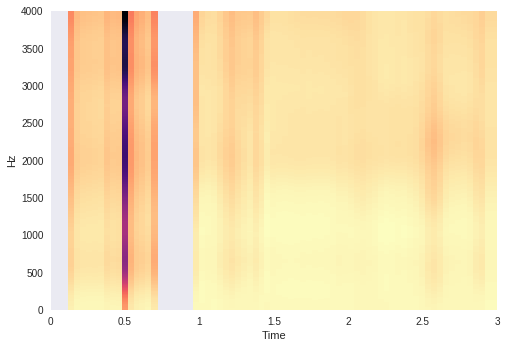

In [0]:
mgc_original = np.fromfile(dir_output + '000099_2019-03-11_20-44-18_LSTM_predicted_PCA_whisper.mgc', dtype=np.float32).reshape(-1, order + 1)
logH_original = pysptk.mgc2sp(np.float64(mgc_original), 0.0, 0.0, frameLength).real
display.specshow(logH_original.T, sr=Fs, hop_length=frameShift, x_axis="time", y_axis="linear")

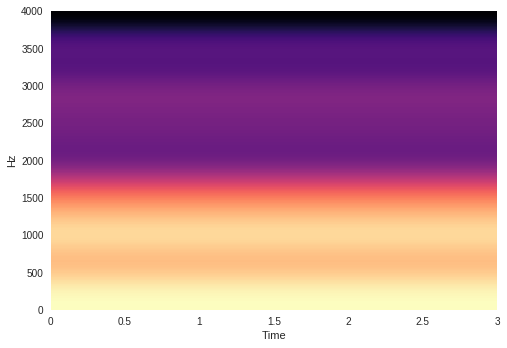

In [0]:
mgc_predicted = np.fromfile(dir_output + '000990_DNN_predicted_PCA_whisper.mgc', dtype=np.float32).reshape(-1, order + 1)
logH_predicted = pysptk.mgc2sp(np.float64(mgc_predicted), 0.0, 0.0, frameLength).real
display.specshow(logH_predicted.T, sr=Fs, hop_length=frameShift, x_axis="time", y_axis="linear")